In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import oommfc as oc

from montecarlo.Driver.driver import driver_numba
from montecarlo.Energies.numba_energies import zeeman_energy, anisotropic_energy, exchange_energy, dmi_energy

In [2]:
region = df.Region(p1=(-50e-9, -50e-9, 0), p2=(50e-9, 50e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(2.5e-9, 2.5e-9, 2.5e-9))

In [3]:
system = mm.System(name='skyrmion')

system.energy = (mm.Exchange(A=1.6e-11)
               + mm.DMI(D=4e-3, crystalclass='Cnv_z')
               + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1))
               + mm.Demag()
               + mm.Zeeman(H=(0, 0, 2e5)))
# system.energy = mm.DMI(D=4e-3, crystalclass='Cnv_z')

In [4]:
Ms = 1.1e6

def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero outside cylindric shape,
    Ms inside cylinder.

    Cylinder radius is 50nm.

    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 50e-9:
        return Ms
    else:
        return 0

def m_init(pos):
    """Function to set initial magnetisation direction:
    -z inside cylinder (r=10nm),
    +z outside cylinder.
    y-component to break symmetry.

    """
    x, y, z = pos
    if (x**2 + y**2)**0.5 < 10e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, dim=3, value=m_init, norm=Ms)

c:\Users\M Gulam Nabi\anaconda3\envs\irp\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
c:\Users\M Gulam Nabi\anaconda3\envs\irp\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


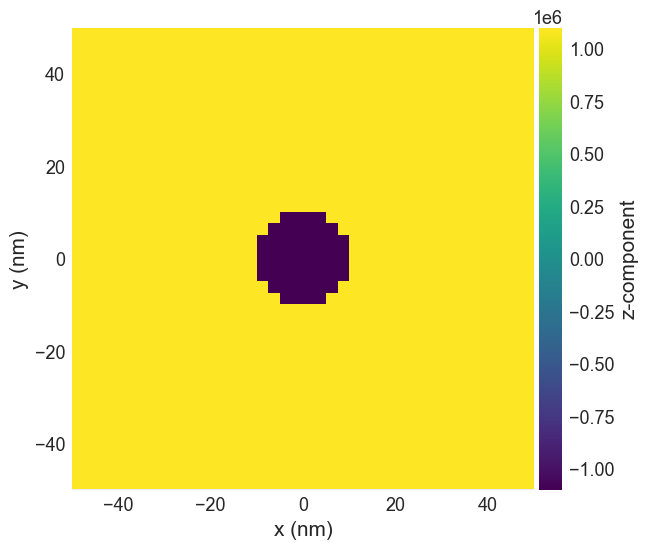

In [5]:
system.m.plane('z').mpl()

In [39]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
# system.m.plane('z').mpl()

Running OOMMF (ExeOOMMFRunner)[2023/08/03 14:13]... (6.5 s)


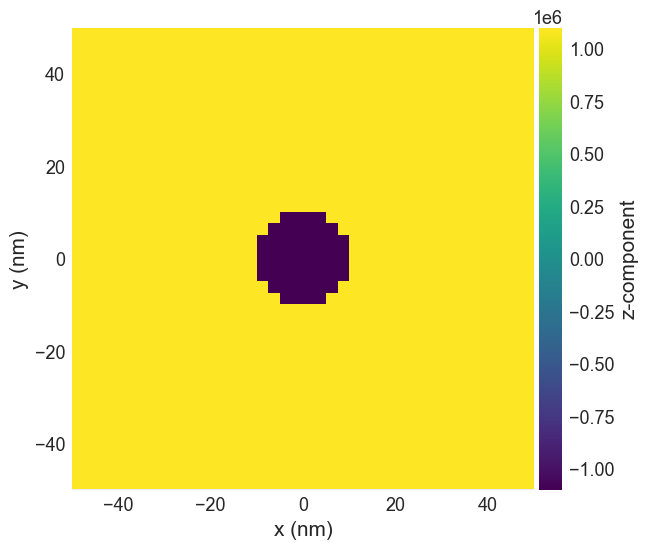

In [6]:
system.m.plane('z').mpl()

In [7]:
charge = df.tools.topological_charge(system.m.plane('z'), method='berg-luescher')
charge

0.0

In [8]:
class MCDriver1():
    def __init__(self, system) -> None:
        self.m0 = 4*np.pi*1e-7 # Tm/A
        self.grid = system.m.array
        magnitudes = np.linalg.norm(self.grid, axis=-1)
        magnitudes[magnitudes == 0] = 1 #avoid division by zero
        self.grid = self.grid/magnitudes[..., np.newaxis] #normalise vectors to get m(r)
        self.dx, self.dy, self.dz = system.m.mesh.cell
        self.temperature = system.T + 0.1 #avoid division by zero
        self.Kb = 1.38064852e-23 #Boltzmann constant
        # What about multiple similar energy terms????
        try:
            self.zeeman_K = np.array(system.energy.zeeman.H)
        except:
            self.zeeman_K = None
        try:
            self.exchange_A =  system.energy.exchange.A
        except:
            self.exchange_A = None
        try:
            self.dmi_D = system.energy.dmi.D
            self.type = system.energy.dmi.crystalclass
        except:
            self.dmi_D = None
        try:
            self.anisotropic_K, self.anisotropic_u = (system.energy.uniaxialanisotropy.K, np.array(system.energy.uniaxialanisotropy.u))
        except:
            self.anisotropic_K, self.anisotropic_u = (None, None)
        try:
            self.demag_N = system.energy.demag.N
        except:
            self.demag_N = None
        
        

In [9]:
# How can I apply better approximation of central difference?
# compare the anisotrophic energy with other's implementation 

charge = df.tools.topological_charge(system.m.plane('z'), method='berg-luescher')
charge


0.0

In [10]:
mc2 = MCDriver1(system)


In [11]:
zeeman_energy(mc2.grid, mc2.zeeman_K, mc2.m0, Ms, mc2.dx, mc2.dy, mc2.dz)

-2.5849024353736815e-17

In [12]:
anisotropic_energy(mc2.grid, mc2.anisotropic_K, mc2.anisotropic_u, mc2.dx, mc2.dy, mc2.dz)

0.0

In [13]:
exchange_energy(mc2.grid, mc2.exchange_A, mc2.dx, mc2.dy, mc2.dz)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUse of unsupported NumPy function 'numpy.pad' or unsupported use of the function.
[1m
File "montecarlo\Energies\numba_energies.py", line 33:[0m
[1mdef exchange_energy(grid, exchange_A, dx, dy, dz):
    <source elided>
        return 0
[1m    grid_pad = np.pad(grid, ((1, 1), (1, 1), (1, 1), (0, 0)), mode='edge') # 'constant'
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: typing of get attribute at c:\Users\M Gulam Nabi\Documents\Courses\Independent Research\montecarlo\Energies\numba_energies.py (33)[0m
[1m
File "montecarlo\Energies\numba_energies.py", line 33:[0m
[1mdef exchange_energy(grid, exchange_A, dx, dy, dz):
    <source elided>
        return 0
[1m    grid_pad = np.pad(grid, ((1, 1), (1, 1), (1, 1), (0, 0)), mode='edge') # 'constant'
[0m    [1m^[0m[0m


In [ ]:
dmi_energy(mc2.grid, mc2.type, mc2.dmi_D, mc2.dx, mc2.dy, mc2.dz)

0.0

In [ ]:
new_grid = driver_numba(10000, mc2.grid, mc2.zeeman_K, mc2.anisotropic_K, mc2.anisotropic_u, mc2.exchange_A, mc2.type, mc2.dmi_D, mc2.m0, Ms, mc2.dx, mc2.dy, mc2.dz, mc2.Kb, mc2.temperature)

In [37]:
iteration = 0
for i in range(50):
    new_grid, acceptance_ratio = driver_numba(100000, mc2.grid, mc2.zeeman_K, mc2.anisotropic_K, mc2.anisotropic_u, mc2.exchange_A, mc2.type, mc2.dmi_D, mc2.m0, Ms, mc2.dx, mc2.dy, mc2.dz, mc2.Kb, mc2.temperature)
    system.m.array = new_grid
    charge = df.tools.topological_charge(system.m.plane('z'), method='berg-luescher')
    iteration += 0.1
    print(f"{iteration} Million, Charge = {charge}, Acceptance Ratio = {acceptance_ratio}")
    mc2.grid = new_grid


0.1 Million, Charge = -0.694750420594446, Acceptance Ratio = 0.50266
0.2 Million, Charge = 0.0005436225364807611, Acceptance Ratio = 0.49905
0.30000000000000004 Million, Charge = 0.0014726492146409855, Acceptance Ratio = 0.49822
0.4 Million, Charge = 0.001919750624571829, Acceptance Ratio = 0.49838
0.5 Million, Charge = 0.003160720593103254, Acceptance Ratio = 0.50086
0.6 Million, Charge = -0.9957793794602425, Acceptance Ratio = 0.50234
0.7 Million, Charge = -0.9949208801603737, Acceptance Ratio = 0.49971
0.7999999999999999 Million, Charge = -0.9940882307927439, Acceptance Ratio = 0.4995
0.8999999999999999 Million, Charge = -0.9924602256201945, Acceptance Ratio = 0.49811
0.9999999999999999 Million, Charge = -0.991701361470637, Acceptance Ratio = 0.5004
1.0999999999999999 Million, Charge = -0.9908199581049535, Acceptance Ratio = 0.501


SystemError: CPUDispatcher(<function driver_numba at 0x000002679F35B640>) returned a result with an exception set

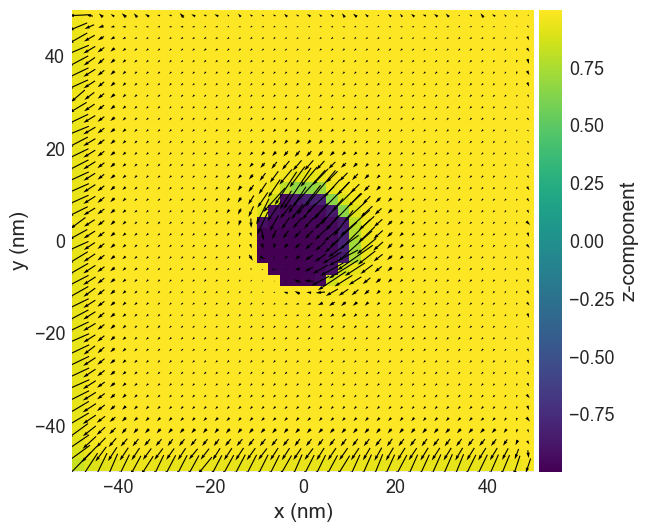

In [38]:
system.m.plane('z').mpl()

## Questions to ask:

1. Little difference between oommfc and my dmi
2. Why did I revese the u vector in anisotrophic energy?
3. How will I be graded because I am using np.gradient which calculates 1sy order accurate at the boundaries.

In [17]:
a = 1/ 0.05

print(np.exp(-a))

2.061153622438558e-09


## Performance
1. Energy calculation is done once per iteration this gives a performance advantage because the gradient, laplacian are not calculated twice.
2. For 10000 iteartions this takes about 6.5seconds 
